<a href="https://colab.research.google.com/github/parmigggiana/ml-ids/blob/main/IDS_CTF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Web attack detection using CTF dataset

## Data preprocessing

In [7]:
import pandas as pd
import numpy as np
from sklearn import preprocessing
import matplotlib.pyplot as plt
%matplotlib inline

In [8]:
#!wget https://github.com/parmigggiana/ml-ids/raw/main/CTF%20Data/ctf_flows_1.csv -O dataset_ctf.csv

In [9]:
#df = pd.read_csv('dataset_ctf.csv')
df = pd.read_csv('CTF Data/ctf_flows_1.csv')

In [10]:
df.shape

(79819, 89)

Make sure that there's no null rows

In [11]:
df = df.drop(df[pd.isnull(df['Flow ID'])].index)
df.shape

(79819, 89)

Drop Label column since it's useless

In [12]:
df.drop(columns='Label', inplace=True)
df.shape

(79819, 88)

Drop all flows pertaining ssh and caronte

In [13]:
df.drop(df[df['Src Port'] == 22].index, inplace=True)
df.drop(df[df['Dst Port'] == 22].index, inplace=True)
df.drop(df[df['Src Port'] == 3333].index, inplace=True)
df.drop(df[df['Dst Port'] == 3333].index, inplace=True)
df.shape

(79472, 88)

Drop all flows made by our team

In [14]:
df.drop(df[df['Src IP'].str.fullmatch(r"10\.80\.39\.\d{1,3}")].index, inplace=True)
df.drop(df[df['Dst IP'].str.fullmatch(r"10\.80\.39\.\d{1,3}")].index, inplace=True)
df.shape

(79471, 88)

In [15]:
df['Src IP'].unique()

array(['10.254.0.1', '10.80.35.2', '172.23.0.2', '10.80.24.6',
       '10.80.36.6', '10.80.24.12', '10.80.22.2', '10.80.36.8',
       '10.80.22.6', '10.80.35.3', '10.80.20.2', '10.80.6.4', '10.80.5.7',
       '10.80.22.4', '10.80.36.9', '10.80.32.2', '10.80.35.7',
       '10.80.22.7', '10.60.39.1', '10.80.21.4', '10.80.22.5',
       '10.80.36.7', '10.80.22.3', '10.80.30.2', '10.80.26.6'],
      dtype=object)

I noticed there's some flows belonging to other addresses. This probably means there's an error in the gameserver, leaking some packets. Upon manual inspection of the pcap, I noticed they are mostly FIN/ACK and RST. 
I chose to keep these flows as it's still actual traffic and we will be removing the IP features anyway

The "Flow Bytes/s" and "Flow Packets/s" columns have non-numerical values, replace them.

In [16]:
df.replace('Infinity', -1, inplace=True)
df[["Flow Bytes/s", "Flow Packets/s"]] = df[["Flow Bytes/s", "Flow Packets/s"]].apply(pd.to_numeric)

Replace the NaN values and infinity values with -1.

In [17]:
df.replace([np.inf, -np.inf, np.nan], -1, inplace=True)

7 features (Flow ID, Source IP, Source Port, Destination IP, Destination Port, Protocol, Timestamp) are excluded from the dataset. The hypothesis is that the "shape" of the data being transmitted is more important than these attributes. In addition, ports and addresses can be substituted by an attacker, so it is better that the ML algorithm does not take these features into account in training [Kostas2018].

In [18]:
excluded = ['Flow ID', 'Src IP', 'Src Port', 'Dst IP', 'Dst Port', 'Protocol', 'Timestamp']
df.drop(columns=excluded, inplace=True)

## Feature Selection

Since we don't have labels, it would be hard to select features: an approach could be removing the ones with low variance or high correlation. 

In [61]:
from pandas.plotting import scatter_matrix
#scatter_matrix(df, diagonal='kde')

array([[<Axes: xlabel='0', ylabel='0'>, <Axes: xlabel='1', ylabel='0'>,
        <Axes: xlabel='2', ylabel='0'>, ...,
        <Axes: xlabel='67', ylabel='0'>, <Axes: xlabel='68', ylabel='0'>,
        <Axes: xlabel='69', ylabel='0'>],
       [<Axes: xlabel='0', ylabel='1'>, <Axes: xlabel='1', ylabel='1'>,
        <Axes: xlabel='2', ylabel='1'>, ...,
        <Axes: xlabel='67', ylabel='1'>, <Axes: xlabel='68', ylabel='1'>,
        <Axes: xlabel='69', ylabel='1'>],
       [<Axes: xlabel='0', ylabel='2'>, <Axes: xlabel='1', ylabel='2'>,
        <Axes: xlabel='2', ylabel='2'>, ...,
        <Axes: xlabel='67', ylabel='2'>, <Axes: xlabel='68', ylabel='2'>,
        <Axes: xlabel='69', ylabel='2'>],
       ...,
       [<Axes: xlabel='0', ylabel='67'>, <Axes: xlabel='1', ylabel='67'>,
        <Axes: xlabel='2', ylabel='67'>, ...,
        <Axes: xlabel='67', ylabel='67'>,
        <Axes: xlabel='68', ylabel='67'>,
        <Axes: xlabel='69', ylabel='67'>],
       [<Axes: xlabel='0', ylabel='68'>, <

Error in callback <function _draw_all_if_interactive at 0x7fc4fec99e40> (for post_execute):


KeyboardInterrupt: 

In [60]:
from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import RobustScaler
#X = df
X = RobustScaler().fit_transform(df)
#selector = VarianceThreshold(0.3)

sorted(X.std(axis=0))
#df = pd.DataFrame(selector.fit_transform(df))
#df.columns[selector.get_support(indices=True)]


[0.8422791265793361,
 0.957552114869972,
 0.9871298205819877,
 0.987129820581988,
 1.003009939922318,
 1.1391218753311068,
 1.468739974020838,
 1.5037068258890707,
 1.7608021902466406,
 2.185681156151111,
 2.644545164302539,
 2.645909634305,
 2.9842550149616396,
 2.9842550149616396,
 4.022326788522407,
 4.67719015620476,
 4.834951842389717,
 5.033343794814601,
 5.110165629775745,
 5.130881428963855,
 5.162016786748011,
 5.922121216525935,
 6.6872012026721785,
 6.68720120267218,
 9.565613396627697,
 9.95942083900962,
 10.09097200080338,
 10.110147781536382,
 10.243776778618432,
 12.470531957152089,
 12.4838627384662,
 13.353256611717546,
 13.823493703914716,
 14.346583487222027,
 15.684307354019033,
 15.802116794093095,
 16.115322434553573,
 16.345491928206584,
 18.17726801667941,
 18.746685303952468,
 19.125677138816,
 19.17984946281915,
 19.327885528259845,
 19.880739668803788,
 20.16543044417056,
 20.40276624022045,
 20.916198583780037,
 22.073741516396904,
 23.252754154236,
 23.2730

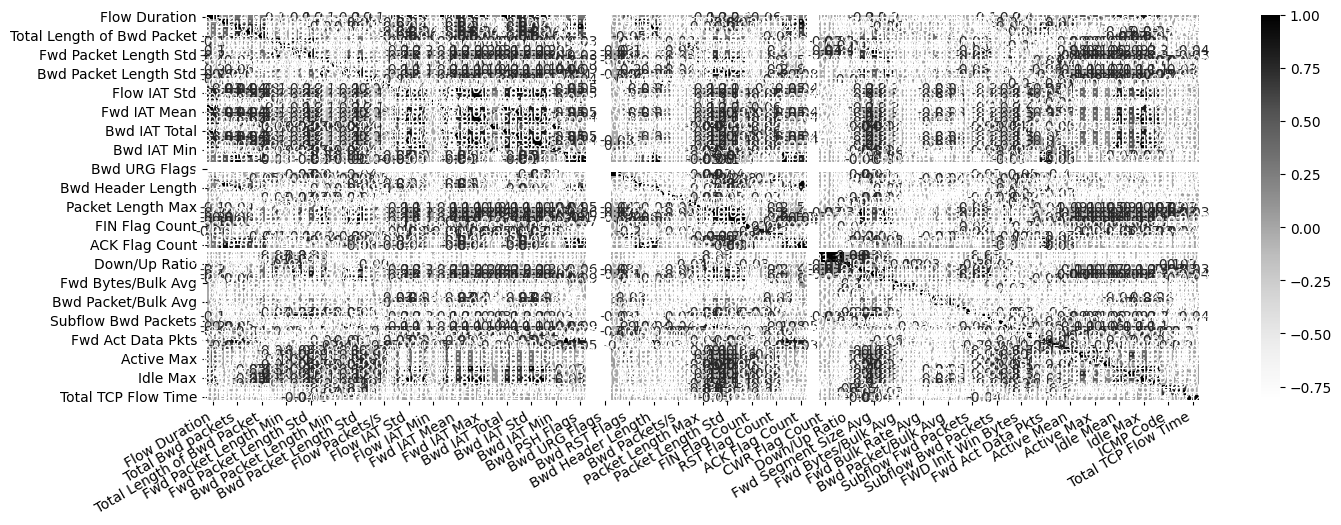

In [25]:
import seaborn as sns
corr_matrix = df.corr()
plt.rcParams['figure.figsize'] = (16, 5)
g = sns.heatmap(corr_matrix, annot=True, fmt='.1g', cmap='Greys')
g.set_xticklabels(g.get_xticklabels(), verticalalignment='top', horizontalalignment='right', rotation=30);
plt.savefig('corr_heatmap.png', dpi=300, bbox_inches='tight')